In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6)

from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant
from keras.layers.merge import add

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_json('News_Category_Dataset_v2.json', lines=True)
df.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [3]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 41
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
THE WORLDPOST      3664
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST 

In [4]:
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [5]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 40
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST          6243
dtype: int

In [7]:
import re
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)

    return string.lower()

In [6]:
# using headlines and short_description as input X

df['text'] = df.headline + " " + df.short_description

# tokenizing

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
X = tokenizer.texts_to_sequences(df.text)
df['words'] = X

# delete some empty and short data

df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]

df = df.drop(df.columns[[0, 2,3,4,5,7,8]], axis=1)

df.shape
df.to_csv('cleaned.csv',encoding='utf-8')
df.head()

In [42]:
df1 = pd.read_csv('cleaned.csv')
X=df1.sample(frac=0.8,random_state=200)
test=df1.drop(X.index)
train=X.sample(frac=0.8,random_state=200)
val=X.drop(train.index)

print(train.shape)
print(val.shape)
print(test.shape)
# train.to_csv('data/news_cat/train.csv', sep='\t')
# val.to_csv('data/news_cat/val.csv', sep='\t')
# test.to_csv('data/news_cat/test.csv', sep='\t')

(127945, 3)
(31986, 3)
(39983, 3)


In [ ]:
clean_df = pd.read_csv('cleaned.csv')
sent_lens = []
sent_nums = []
for idx in range(clean_df.text.shape[0]):
    clean_df.text[idx] = clean_str(clean_df.text[idx])

clean_df.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [ ]:
train=df.sample(frac=0.8[p,random_state=200)
test=df.drop(train.index)

In [10]:
df.word_length.describe()

count    199914.000000
mean         29.725032
std          14.024717
min           5.000000
25%          20.000000
50%          29.000000
75%          36.000000
max         248.000000
Name: word_length, dtype: float64

In [11]:
maxlen = 50
X = list(sequence.pad_sequences(df.words, maxlen=maxlen))

In [12]:
categories = df.groupby('category').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['category'].apply(lambda x: category_int[x])


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
word_index = tokenizer.word_index

EMBEDDING_DIM = 300

embeddings_index = {}
f = open('glove.840B.300d.txt')
for line in f:
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s unique tokens.' % len(word_index))
print('Total %s word vectors.' % len(embeddings_index))

Found 116617 unique tokens.
Total 2195892 word vectors.


In [15]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

In [16]:
# prepared data 

X = np.array(X)
Y = np_utils.to_categorical(list(df.c2id))

# and split to training set and validation set

seed = 29
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [ ]:
# Bidrectional LSTM with convolution
# from https://www.kaggle.com/eashish/bidirectional-gru-with-convolution

inp = Input(shape=(maxlen,), dtype='int32')
x = embedding_layer(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = Conv1D(64, kernel_size=3)(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
outp = Dense(len(int_category), activation="softmax")(x)

BiGRU = Model(inp, outp)
BiGRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

BiGRU.summary()

In [ ]:
bigru_history = BiGRU.fit(x_train, 
                          y_train, 
                          batch_size=128, 
                          epochs=20, 
                          validation_data=(x_val, y_val))

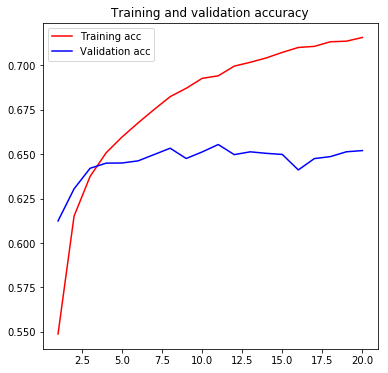

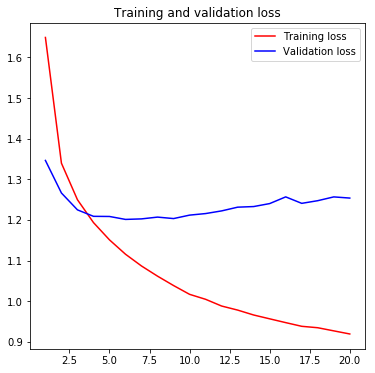

In [20]:
plt.rcParams['figure.figsize'] = (6,6)

acc = bigru_history.history['acc']
val_acc = bigru_history.history['val_acc']
loss = bigru_history.history['loss']
val_loss = bigru_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

In [17]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    

lstm_layer = LSTM(300, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)

inp = Input(shape=(maxlen,), dtype='int32')
embedding= embedding_layer(inp)
x = lstm_layer(embedding)
x = Dropout(0.25)(x)
merged = Attention(maxlen)(x)
merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.25)(merged)
merged = BatchNormalization()(merged)
outp = Dense(len(int_category), activation='softmax')(merged)

AttentionLSTM = Model(inputs=inp, outputs=outp)
AttentionLSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

AttentionLSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 300)           34985400  
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 300)           721200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
attention_1 (Attention)      (None, 300)               350       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

In [18]:
attlstm_history = AttentionLSTM.fit(x_train, 
                                    y_train, 
                                    batch_size=128, 
                                    epochs=20, 
                                    validation_data=(x_val, y_val))

Train on 159931 samples, validate on 39983 samples
Epoch 1/20
159931/159931 [==============================] - 126s 788us/step - loss: 1.6651 - acc: 0.5483 - val_loss: 1.3324 - val_acc: 0.6139
Epoch 2/20
159931/159931 [==============================] - 99s 622us/step - loss: 1.3665 - acc: 0.6104 - val_loss: 1.2331 - val_acc: 0.6389
Epoch 3/20
159931/159931 [==============================] - 99s 618us/step - loss: 1.2669 - acc: 0.6322 - val_loss: 1.1892 - val_acc: 0.6479
Epoch 4/20
159931/159931 [==============================] - 104s 650us/step - loss: 1.2039 - acc: 0.6463 - val_loss: 1.1635 - val_acc: 0.6558
Epoch 5/20
159931/159931 [==============================] - 99s 619us/step - loss: 1.1514 - acc: 0.6582 - val_loss: 1.1386 - val_acc: 0.6629
Epoch 6/20
159931/159931 [==============================] - 98s 614us/step - loss: 1.1074 - acc: 0.6684 - val_loss: 1.1258 - val_acc: 0.6664
Epoch 7/20
159931/159931 [==============================] - 98s 615us/step - loss: 1.0675 - acc: 0.67

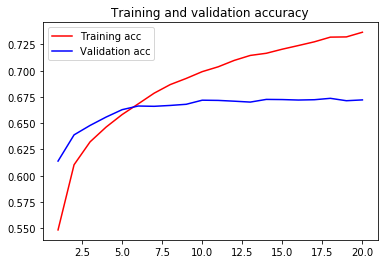

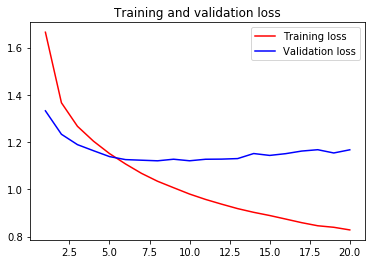

In [19]:
acc = attlstm_history.history['acc']
val_acc = attlstm_history.history['val_acc']
loss = attlstm_history.history['loss']
val_loss = attlstm_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()